[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/4.2.make_additional_datasets.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

Классификатор будет обучаться на датасете RTSD (знаки кадрируются по bbox).  
Так как во многих классах знаков очень мало - необходимо найти другие датасеты дорожных знаков.

## Обогащение обучающего датасета знаками из других датасетов:
- German Traffic Sign Recognition Benchmark (GTSRB);
- BelgiumTS Dataset;
- Chinese Traffic Signs.

In [ ]:
colab = False

if colab == True:
    #!pip install fiftyone
    !pip install kaggle

        
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !mkdir data

    !kaggle datasets download watchman/rtsd-dataset
    !mkdir data/RTSD
    !unzip  -q rtsd-dataset.zip -d ./data/RTSD/
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    
    !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !mkdir data/GTSRB
    !unzip -q gtsrb-german-traffic-sign.zip -d ./data/GTSRB/
    !rm gtsrb-german-traffic-sign.zip

    !kaggle datasets download mahadevkonar/belgiumts-dataset
    !mkdir data/BelgiumTS
    !unzip -q belgiumts-dataset.zip -d .data/BelgiumTS/
    !rm belgiumts-dataset.zip

    !kaggle datasets download dmitryyemelyanov/chinese-traffic-signs
    !mkdir data/ChineseTS
    !unzip -q chinese-traffic-signs.zip -d ./data/ChineseTS/
    !rm chinese-traffic-signs.zip

In [1]:
import json
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from PIL import Image

In [2]:
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

In [3]:
def make_df_to_anno(df, path=None):
    '''
    функция принимает на вход датафрейм (колонки file_name, width, height, bbox, category_id, name)
    и возвразает аннотацию в формате COCO
    '''
    # словарь уникальное изображение - ID (для быстрого опререления существования аннотации изображения)
    path2id = {}

    # списки для формирования элементов аннотации
    images = []         # список описаний изображений
    annotations = []    # список описаний аннотаций
    
    # для каждой строки датафрейма
    for i in range(df.shape[0]):
        # пытаемся получить ID изображеня в словаре для быстрого поиска
        path = df.at[i,'file_name']
        try:
            image_ID = path2id[path]
        # при отсутствии изображения в словаре для быстрого поиска
        except:
            # добавляем изображение и следующий ID в словарь для быстрого поиска
            image_ID = len(path2id)
            path2id[path] = image_ID
            # формируем описание изображения и добавляем его в список
            image_item = {}
            image_item['id'] = image_ID
            image_item['width'] = df.at[i,'width']
            image_item['height'] = df.at[i,'height']
            image_item['file_name'] = path
            images.append(image_item)
        
        # формируем описание аннотации и добавляем его в список
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = image_ID
        anno_item['category_id'] = df.at[i,'category_id']
        bbox = df.at[i,'bbox']
        anno_item['area'] = bbox[2]*bbox[3]
        anno_item['bbox'] = bbox
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)

    # формируем список описаний категорий
    categories = df[['category_id', 'name']].drop_duplicates()
    categories.sort_values(by=['category_id'], inplace=True)
    categories.set_index('category_id', inplace=True)
    categories = categories.to_dict()['name']
    categories = [{'id':category_id, 'name':name} for category_id, name in categories.items()]
    
    # формирование аннотации датасета в формате COCO
    anno = {}
    anno['images'] = images
    anno['annotations'] = annotations
    anno['categories'] = categories

    return anno

In [4]:
class NpEncoder(json.JSONEncoder):
    '''
    класс энкодер для конвертации типов данных NumPy в Python перед сериализацией объекта
    '''
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

## Обучающая выборка RTSD

In [5]:
# Аннотация обучающей выборки RTSD
with open(os.path.join(dataset_path, 'train_anno.json'), 'r') as read_file:
    RTSD_train_anno = json.load(read_file)
read_file.close()

# Загрузка аннотаций в датафрейм
RTSD_train = pd.DataFrame(RTSD_train_anno.get('annotations'))
# Добавление путей к файлам
RTSD_train_images = pd.DataFrame(RTSD_train_anno.get('images'))
RTSD_train = RTSD_train.merge(RTSD_train_images, left_on='image_id', right_on='id')
# Добавление имен категорий (кодов знаков)
RTSD_train_category = pd.DataFrame(RTSD_train_anno.get('categories'))
RTSD_train = RTSD_train.merge(RTSD_train_category, left_on='category_id', right_on='id')[['file_name','width','height',
                                                                                          'bbox','category_id','name']]

RTSD_train

,file_name,width,height,bbox,category_id,name
0,rtsd-frames/autosave01_02_2012_09_13_33.jpg,1280,720,"[649, 376, 18, 18]",1,2_1
1,rtsd-frames/autosave01_02_2012_09_13_34.jpg,1280,720,"[671, 356, 20, 21]",1,2_1
2,rtsd-frames/autosave01_02_2012_09_13_35.jpg,1280,720,"[711, 332, 27, 26]",1,2_1
3,rtsd-frames/autosave01_02_2012_09_13_36.jpg,1280,720,"[764, 290, 37, 36]",1,2_1
4,rtsd-frames/autosave01_02_2012_09_13_37.jpg,1280,720,"[876, 200, 56, 57]",1,2_1
...,...,...,...,...,...,...
95487,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg,1280,720,"[767, 306, 39, 60]",154,7_14
95488,rtsd-frames/autosave24_10_2013_11_23_20_1.jpg,1280,720,"[1143, 101, 112, 151]",154,7_14
95489,rtsd-frames/autosave24_10_2013_11_29_00_0.jpg,1280,720,"[762, 367, 36, 17]",155,8_23
95490,rtsd-frames/autosave24_10_2013_11_29_00_1.jpg,1280,720,"[878, 346, 56, 26]",155,8_23


## Датасет German Traffic Sign Recognition Benchmark (GTSRB)
https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Датасет содержит 3 каталога и 3 файла аннотации:
- Meta
- Train
- Test
- Meta.csv
- Train.csv
- Test.csv

### Meta

In [6]:
Meta = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Meta.csv'))
Meta

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


Анализ знаков GTSRB и сопоставление с российскими знаками

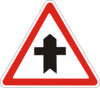

In [7]:
class_id = 11
Image.open(os.path.join(dataset_path, 'GTSRB', f'Meta/{class_id}.png'))

**Расшифровка знаков GTSRB и соотнесение с кодами российских знаков**
ClassId | Наименование знака | Код знака (ГОСТ)
|:---:|---|---|
0 | Ограничение скорости (20) | 3_24
1 | Ограничение скорости (30) | 3_24
2 | Ограничение скорости (50) | 3_24
3 | Ограничение скорости (60) | 3_24
4 | Ограничение скорости (70) | 3_24
5 | Ограничение скорости (80) | 3_24
6 | Конец ограничения скорости (80) | 3_25
7 | Ограничение скорости (100) | 3_24
8 | Ограничение скорости (120) | 3_24
9 | Обгон запрещен | 3_20
10 | Обгон для грузовых автомобилей более 3,5т запрещен | -
11 | Пересечение со второстепенной дорогой (немного не похож) | 2_3
12 | Главная дорога | 2_1
13 | Уступи дорогу | 2_4
14 | Стоп | 2_5
15 | Движение запрещено | 3_2
16 | Автомобилям весом более 3,5т проезд запрещен | 3_4_1
17 | Въезд запрещен (кирпич) | 3_1
18 | Опасность на дороге (восклицательный знак) | 1_33
19 | Опасный поворот (налево) | 1_11_1
20 | Опасный поворот (направо) | 1_11
21 | Опасные повороты (в российском влево и вправо отличаются) | -
22 | Неровная дорога (желтая) | 1_16
23 | Опасность заноса или скольжения | 1_15
24 | Сужение дороги (в российском слева и справа отличаются) | -
25 | Дорожные работы | 1_25
26 | Светофор | 1_8
27 | Осторожно пешеходы | 1_22
28 | Осторожно дети (немного отличается) | 1_23   
29 | Осторожно велосипедисты (в российских нет) | -
30 | Скольжение из-за снега или льда (в российских нет) | -
31 | Дикие животные | 1_27              
32 | Конец всех ограничений | 3_31
33 | Движение направо | 4_1_2
34 | Движение налево | 4_1_3
35 | Движение прямо | 4_1_1
36 | Прямо или направо | 4_1_4
37 | Прямо или налево | 4_1_5
38 | Объезд справа | 4_2_1  
39 | Объезд слева | 4_2_2
40 | Круговое движение | 4_3
41 | Конец зоны запрещения обгона | 3_21
42 | Конец зоны запрещения обгона авто более 3,5т | -

In [8]:
# Словарь с маппингом категорий German Traffic Sign Recognition Benchmark (GTSRB) на Российские знаки (которые есть в RTSD)
GTSRB_to_RTSD_labels = {}
GTSRB_to_RTSD_labels[0] = '3_24'
GTSRB_to_RTSD_labels[1] = '3_24'
GTSRB_to_RTSD_labels[2] = '3_24'
GTSRB_to_RTSD_labels[3] = '3_24'
GTSRB_to_RTSD_labels[4] = '3_24'
GTSRB_to_RTSD_labels[5] = '3_24'
GTSRB_to_RTSD_labels[6] = '3_25'
GTSRB_to_RTSD_labels[7] = '3_24'
GTSRB_to_RTSD_labels[8] = '3_24'           
GTSRB_to_RTSD_labels[9] = '3_20'
GTSRB_to_RTSD_labels[11] = '2_3'
GTSRB_to_RTSD_labels[12] = '2_1'
GTSRB_to_RTSD_labels[13] = '2_4'
GTSRB_to_RTSD_labels[14] = '2_5'
GTSRB_to_RTSD_labels[15] = '3_2'
GTSRB_to_RTSD_labels[16] = '3_4_1'     
GTSRB_to_RTSD_labels[17] = '3_1'
GTSRB_to_RTSD_labels[18] = '1_33'
GTSRB_to_RTSD_labels[19] = '1_11_1'
GTSRB_to_RTSD_labels[20] = '1_11'
GTSRB_to_RTSD_labels[22] = '1_16'
GTSRB_to_RTSD_labels[23] = '1_15'
GTSRB_to_RTSD_labels[25] = '1_25'
GTSRB_to_RTSD_labels[26] = '1_8'
GTSRB_to_RTSD_labels[27] = '1_22'
GTSRB_to_RTSD_labels[28] = '1_23'   
GTSRB_to_RTSD_labels[31] = '1_27'              
GTSRB_to_RTSD_labels[32] = '3_31'
GTSRB_to_RTSD_labels[33] = '4_1_2'
GTSRB_to_RTSD_labels[34] = '4_1_3'
GTSRB_to_RTSD_labels[35] = '4_1_1'
GTSRB_to_RTSD_labels[36] = '4_1_4'
GTSRB_to_RTSD_labels[37] = '4_1_5'
GTSRB_to_RTSD_labels[38] = '4_2_1'  
GTSRB_to_RTSD_labels[39] = '4_2_2'
GTSRB_to_RTSD_labels[40] = '4_3'
GTSRB_to_RTSD_labels[41] = '3_21'
GTSRB_to_RTSD_labels

{0: '3_24',
 1: '3_24',
 2: '3_24',
 3: '3_24',
 4: '3_24',
 5: '3_24',
 6: '3_25',
 7: '3_24',
 8: '3_24',
 9: '3_20',
 11: '2_3',
 12: '2_1',
 13: '2_4',
 14: '2_5',
 15: '3_2',
 16: '3_4_1',
 17: '3_1',
 18: '1_33',
 19: '1_11_1',
 20: '1_11',
 22: '1_16',
 23: '1_15',
 25: '1_25',
 26: '1_8',
 27: '1_22',
 28: '1_23',
 31: '1_27',
 32: '3_31',
 33: '4_1_2',
 34: '4_1_3',
 35: '4_1_1',
 36: '4_1_4',
 37: '4_1_5',
 38: '4_2_1',
 39: '4_2_2',
 40: '4_3',
 41: '3_21'}

Примечания:
- Знак категории 11 - Пересечение со второстепенной дорогой (немного отличается)    '2_3';
- Знак категории 28 - Осторожно дети (немного отличается)                           '1_23'   

### Train

In [9]:
Train = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Train.csv'))
Train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


Визуализация знаков обучающей выборки GTSRB

In [10]:
class_id = 16
index = 0

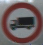

In [11]:
df = Train[Train['ClassId'] == class_id].copy()
df.reset_index(inplace=True)
img_name = df.loc[index, 'Path']
bbox = [df.loc[index, 'Roi.X1'], df.loc[index, 'Roi.Y1'], df.loc[index, 'Roi.X2'], df.loc[index, 'Roi.Y2']]
index+=1
Image.open(os.path.join(dataset_path, 'GTSRB', img_name)).crop(bbox)

Приведение обучающей выборки GTSRB к виду RTSD

In [12]:
# Формирование датафрейма из обучающей выборки
GTSRB_train = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Train.csv'))
# Корректировка пути к изображению
GTSRB_train['Path'] = GTSRB_train['Path'].apply(lambda x: 'GTSRB/' + x)
# Формирование столбца bbox в формате COCO (x1, y1, w, h)
GTSRB_train.reset_index(inplace=True) 
GTSRB_train['bbox'] = GTSRB_train['index'].apply(lambda x: [GTSRB_train.at[x,'Roi.X1'], GTSRB_train.at[x,'Roi.Y1'],
                                                            GTSRB_train.at[x,'Roi.X2'] - GTSRB_train.at[x,'Roi.X1'],
                                                            GTSRB_train.at[x,'Roi.Y2'] - GTSRB_train.at[x,'Roi.Y1']
                                                            ])
# Добавим российские коды знаков (ГОСТ) в датасет
GTSRB_train = GTSRB_train.merge(pd.DataFrame([GTSRB_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
# Добавим ID категорий знаков из RTSD
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
GTSRB_train = GTSRB_train.merge(pd.DataFrame([label_map]).T, left_on=0, right_index=True)
# Оставим нужные колонки и переименуем их
GTSRB_train.rename(columns={'Path':'file_name', 'Width':'width', 'Height':'height', '0_x':'name', '0_y':'category_id'}, inplace=True)
GTSRB_train = GTSRB_train[['file_name','width','height','bbox','category_id','name']]
# сброс индекса
GTSRB_train.reset_index(inplace=True)
del GTSRB_train['index']

GTSRB_train

,file_name,width,height,bbox,category_id,name
0,GTSRB/Train/20/00020_00000_00000.png,27,26,"[5, 5, 17, 15]",62,1_11
1,GTSRB/Train/20/00020_00000_00001.png,28,27,"[5, 6, 18, 16]",62,1_11
2,GTSRB/Train/20/00020_00000_00002.png,29,26,"[6, 5, 18, 16]",62,1_11
3,GTSRB/Train/20/00020_00000_00003.png,28,27,"[5, 6, 18, 16]",62,1_11
4,GTSRB/Train/20/00020_00000_00004.png,28,26,"[5, 5, 18, 16]",62,1_11
...,...,...,...,...,...,...
35634,GTSRB/Train/41/00041_00007_00025.png,57,58,"[5, 5, 47, 48]",102,3_21
35635,GTSRB/Train/41/00041_00007_00026.png,59,60,"[6, 5, 48, 50]",102,3_21
35636,GTSRB/Train/41/00041_00007_00027.png,60,63,"[5, 5, 50, 53]",102,3_21
35637,GTSRB/Train/41/00041_00007_00028.png,63,65,"[6, 6, 52, 54]",102,3_21


Формирование файла аннотации GTSRB Train

In [13]:
GTSRB_train_anno = make_df_to_anno(df = GTSRB_train)
# сохранение аннотации в файл
with open(os.path.join(dataset_path, 'GTSRB_train_anno.json'), 'w') as f:
    json.dump(GTSRB_train_anno, f, cls=NpEncoder)
f.close()

### Test

In [14]:
Test = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Test.csv'))
Test

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


Визуализация знаков валидационной выборки GTSRB

In [15]:
class_id = 16
index = 0

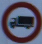

In [16]:
df = Test[Test['ClassId'] == class_id].copy()
df.reset_index(inplace=True)
img_name = df.loc[index, 'Path']
bbox = [df.loc[index, 'Roi.X1'], df.loc[index, 'Roi.Y1'], df.loc[index, 'Roi.X2'], df.loc[index, 'Roi.Y2']]
index+=1
Image.open(os.path.join(dataset_path, 'GTSRB', img_name)).crop(bbox)

Приведение валидационной выборки GTSRB к виду RTSD

In [17]:
# Формирование датафрейма из валидационной выборки
GTSRB_val = pd.read_csv(os.path.join(dataset_path, 'GTSRB', 'Test.csv'))
# Корректировка пути к изображению
GTSRB_val['Path'] = GTSRB_val['Path'].apply(lambda x: 'GTSRB/' + x)
# Формирование столбца bbox в формате COCO (x1, y1, w, h)
GTSRB_val.reset_index(inplace=True) 
GTSRB_val['bbox'] = GTSRB_val['index'].apply(lambda x: [GTSRB_val.at[x,'Roi.X1'], GTSRB_val.at[x,'Roi.Y1'],
                                                        GTSRB_val.at[x,'Roi.X2'] - GTSRB_val.at[x,'Roi.X1'],
                                                        GTSRB_val.at[x,'Roi.Y2'] - GTSRB_val.at[x,'Roi.Y1']
                                                        ])
# Добавим российские коды знаков (ГОСТ) в датасет
GTSRB_val = GTSRB_val.merge(pd.DataFrame([GTSRB_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
# Добавим ID категорий знаков из RTSD
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
GTSRB_val = GTSRB_val.merge(pd.DataFrame([label_map]).T, left_on=0, right_index=True)
# Оставим нужные колонки и переименуем их
GTSRB_val.rename(columns={'Path':'file_name', 'Width':'width', 'Height':'height', '0_x':'name', '0_y':'category_id'}, inplace=True)
GTSRB_val = GTSRB_val[['file_name','width','height','bbox','category_id','name']]
# сброс индекса
GTSRB_val.reset_index(inplace=True)
del GTSRB_val['index']

GTSRB_val

,file_name,width,height,bbox,category_id,name
0,GTSRB/Test/00000.png,53,54,"[6, 5, 42, 44]",20,3_4_1
1,GTSRB/Test/00038.png,30,31,"[5, 6, 20, 20]",20,3_4_1
2,GTSRB/Test/00059.png,36,37,"[6, 5, 25, 27]",20,3_4_1
3,GTSRB/Test/00112.png,39,42,"[6, 6, 28, 30]",20,3_4_1
4,GTSRB/Test/00161.png,32,32,"[6, 6, 21, 21]",20,3_4_1
...,...,...,...,...,...,...
11455,GTSRB/Test/11662.png,61,58,"[6, 6, 49, 47]",87,4_1_5
11456,GTSRB/Test/12060.png,47,46,"[6, 6, 35, 34]",87,4_1_5
11457,GTSRB/Test/12076.png,67,68,"[6, 7, 55, 55]",87,4_1_5
11458,GTSRB/Test/12341.png,51,50,"[6, 6, 39, 38]",87,4_1_5


Формирование файла аннотации GTSRB Val

In [18]:
GTSRB_val_anno = make_df_to_anno(df = GTSRB_val)
# сохранение аннотации в файл
with open(os.path.join(dataset_path, 'GTSRB_val_anno.json'), 'w') as f:
    json.dump(GTSRB_val_anno, f, cls=NpEncoder)
f.close()

## Датасет BelgiumTS Dataset
https://www.kaggle.com/datasets/mahadevkonar/belgiumts-dataset

Датасет содержит каталоги:
- BelgiumTSC_Training/Training;
- BelgiumTSC_Testing/Testing.  
Каждый из каталогов содержит каталоги с именами 00000 - 00061 с изображениями соответствующих классов

### Train

In [19]:
BelgiumTSC_train = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Training/Training/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_train = pd.concat((BelgiumTSC_train, df_temp), ignore_index=True)
BelgiumTSC_train

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,BelgiumTSC_Training/Training/00031/00050_00000...,285,285,24,24,260,261,31
1,BelgiumTSC_Training/Training/00031/00050_00001...,191,193,16,16,175,176,31
2,BelgiumTSC_Training/Training/00031/00050_00002...,135,133,11,11,123,122,31
3,BelgiumTSC_Training/Training/00031/00060_00000...,142,122,12,10,130,111,31
4,BelgiumTSC_Training/Training/00031/00060_00001...,141,143,12,12,129,131,31
...,...,...,...,...,...,...,...,...
4586,BelgiumTSC_Training/Training/00044/01967_00001...,176,118,15,10,160,108,44
4587,BelgiumTSC_Training/Training/00044/01967_00002...,115,75,10,6,105,69,44
4588,BelgiumTSC_Training/Training/00044/01969_00000...,302,213,25,18,276,195,44
4589,BelgiumTSC_Training/Training/00044/01969_00001...,166,111,14,9,151,101,44


Анализ знаков BelgiumTSC и сопоставление с российскими знаками

In [20]:
class_id = 15
index = 0

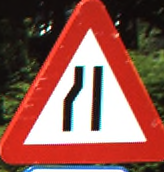

In [21]:
df = BelgiumTSC_train[BelgiumTSC_train['ClassId'] == class_id].copy()
df.reset_index(inplace=True)
img_name = df.loc[index, 'Filename']
bbox = [df.loc[index, 'Roi.X1'], df.loc[index, 'Roi.Y1'], df.loc[index, 'Roi.X2'], df.loc[index, 'Roi.Y2']]
index+=1
Image.open(os.path.join(dataset_path, 'BelgiumTSC', img_name)).crop(bbox)

**Расшифровка знаков BelgiumTSC и соотнесение с кодами российских знаков**
ClassId | Наименование знака | Код знака (ГОСТ)
|:---:|---|---|
0 | Ухабистая дорога | 1_16
1 | Отбойник (лежачий полицейский) | 1_17
2 | Скользкая дорога  | 1_15
3 | Опасный поворот (налево) | 1_11_1
4 | Опасный поворот (направо) | 1_11       
5 | Опасные повороты (первый налево) | 1_12_2
6 | Опасные повороты (первый направо) | 1_12
7 | Школьная зона (немного не похоже) | 1_23
8 | Велосипеды могут пересекать (в RTSD нет) | -
9 | Пересечение домашних животных | 1_26
10 | Ремонтные работы | 1_25
11 | Светофор | 1_8
12 | Закрытый железнодорожный переезд впереди | 1_1
13 | Осторожно | 1_33
14 | Дорога сужается | 1_20
15 | Дорога сужается слева | 1_20_3
16 | Дорога сужается справа | 1_20_2
17 | пересечение с второстепенной  дорогой (в RTSD разбито на категории) | -
18 | перекресток с приоритетом направо | 1_6
19 | Уступить дорогу | 2_4
20 | Преимущество встречного движения | 2_6
21 | Остановитесь и уступите дорогу | 2_5
22 | Запрещенное направление для всех водителей | 3_1
23 | водителям велосипедов въезд запрещен | -
24 | Ограничение по массе | 3_11
25 | Грузовым въезд запрещен | 3_4
26 | Ограничение по ширине | 3_14
27 | Ограничение по высоте | 3_13
28 | Въезд запрещен (движение) | 3_2
29 | Поворот налево запрещен | 3_18_2
30 | Поворот направо запрещен | 3_18
31 | запрещен обгон транспортных средств | 3_20
32 | Ограничение скорости | 3_24
33 | Велопешеходная дорожка с совмещенным движением | -
34 | Движение прямо | 4_1_1
35 | Движение абы куда (стрелка) | -
36 | Движение прямо и направо | 4_1_4
37 | Круговое движение | 4_3
38 | Обязательная велосипедная дорожка | -
39 | Велопешеходная дорожка с разделением движения | -
40 | Парковка запрещена | 3_28
41 | Парковка и остановка запрещены | 3_27
42 | Парковка запрещена с 1 по 15 число месяца | -
43 | Парковка запрещена с 15-го | -
44 | Преимущество перед встречным движением | 2_7
45 | Парковка разрешена | 6_4
46 | Парковка, предназначенная для инвалидов | 6_4
47 | парковка, предназначенная для ... | 6_4
48 | Парковка, предназначенная для грузовиков | 6_4
49 | Парковка, предназначенная для автобусов | 6_4
50 | парковка на обочине или тротуаре | 6_4
51 | Начало живой улицы | 5_21            
52 | Конец оживленной улицы | 5_22
53 | дорога с односторонним движением | 5_5
54 | Тупик | 6_8_1
55 | Окончание дорожных работ | -
56 | Пешеходный переход (немного не похож) | 5_19_1
57 | пересечение велосипедиста и мопеда | -
58 | Автостоянка | -
59 | Горб | 5_20
60 | Конец приоритетной дороги | 2_2
61 | Приоритетная дорога | 2_1

In [22]:
# Словарь с маппингом категорий BelgiumTSC на Российские знаки (которые есть в RTSD)
BelgiumTSC_to_RTSD_labels = {}
BelgiumTSC_to_RTSD_labels[0] = '1_16'                      
BelgiumTSC_to_RTSD_labels[1] = '1_17'
BelgiumTSC_to_RTSD_labels[2] = '1_15'
BelgiumTSC_to_RTSD_labels[3] = '1_11_1'
BelgiumTSC_to_RTSD_labels[4] = '1_11'    
BelgiumTSC_to_RTSD_labels[5] = '1_12_2'
BelgiumTSC_to_RTSD_labels[6] = '1_12'
BelgiumTSC_to_RTSD_labels[7] = '1_23'
BelgiumTSC_to_RTSD_labels[9] = '1_26'
BelgiumTSC_to_RTSD_labels[10] = '1_25'
BelgiumTSC_to_RTSD_labels[11] = '1_8'
BelgiumTSC_to_RTSD_labels[12] = '1_1'
BelgiumTSC_to_RTSD_labels[13] = '1_33'
BelgiumTSC_to_RTSD_labels[14] = '1_20'
BelgiumTSC_to_RTSD_labels[15] = '1_20_3'
BelgiumTSC_to_RTSD_labels[16] = '1_20_2'
BelgiumTSC_to_RTSD_labels[18] = '1_6'
BelgiumTSC_to_RTSD_labels[19] = '2_4'
BelgiumTSC_to_RTSD_labels[20] = '2_6'
BelgiumTSC_to_RTSD_labels[21] = '2_5'
BelgiumTSC_to_RTSD_labels[22] = '3_1' 
BelgiumTSC_to_RTSD_labels[24] = '3_11'
BelgiumTSC_to_RTSD_labels[25] = '3_4'
BelgiumTSC_to_RTSD_labels[26] = '3_14'
BelgiumTSC_to_RTSD_labels[27] = '3_13'
BelgiumTSC_to_RTSD_labels[28] = '3_2'
BelgiumTSC_to_RTSD_labels[29] = '3_18_2'
BelgiumTSC_to_RTSD_labels[30] = '3_18'
BelgiumTSC_to_RTSD_labels[31] = '3_20'
BelgiumTSC_to_RTSD_labels[32] = '3_24'
BelgiumTSC_to_RTSD_labels[34] = '4_1_1'
BelgiumTSC_to_RTSD_labels[36] = '4_1_4'
BelgiumTSC_to_RTSD_labels[37] = '4_3'
BelgiumTSC_to_RTSD_labels[40] = '3_28'
BelgiumTSC_to_RTSD_labels[41] = '3_27'
BelgiumTSC_to_RTSD_labels[42] = '3_27'
BelgiumTSC_to_RTSD_labels[43] = '3_27'
BelgiumTSC_to_RTSD_labels[44] = '2_7'
BelgiumTSC_to_RTSD_labels[45] = '6_4'
BelgiumTSC_to_RTSD_labels[46] = '6_4'
BelgiumTSC_to_RTSD_labels[47] = '6_4'
BelgiumTSC_to_RTSD_labels[48] = '6_4'
BelgiumTSC_to_RTSD_labels[49] = '6_4'
BelgiumTSC_to_RTSD_labels[50] = '6_4'
BelgiumTSC_to_RTSD_labels[51] = '5_21'
BelgiumTSC_to_RTSD_labels[52] = '5_22'
BelgiumTSC_to_RTSD_labels[53] = '5_5'
BelgiumTSC_to_RTSD_labels[54] = '6_8_1'
BelgiumTSC_to_RTSD_labels[56] = '5_19_1'
BelgiumTSC_to_RTSD_labels[59] = '5_20'
BelgiumTSC_to_RTSD_labels[60] = '2_2'
BelgiumTSC_to_RTSD_labels[61] = '2_1'
BelgiumTSC_to_RTSD_labels

{0: '1_16',
 1: '1_17',
 2: '1_15',
 3: '1_11_1',
 4: '1_11',
 5: '1_12_2',
 6: '1_12',
 7: '1_23',
 9: '1_26',
 10: '1_25',
 11: '1_8',
 12: '1_1',
 13: '1_33',
 14: '1_20',
 15: '1_20_3',
 16: '1_20_2',
 18: '1_6',
 19: '2_4',
 20: '2_6',
 21: '2_5',
 22: '3_1',
 24: '3_11',
 25: '3_4',
 26: '3_14',
 27: '3_13',
 28: '3_2',
 29: '3_18_2',
 30: '3_18',
 31: '3_20',
 32: '3_24',
 34: '4_1_1',
 36: '4_1_4',
 37: '4_3',
 40: '3_28',
 41: '3_27',
 42: '3_27',
 43: '3_27',
 44: '2_7',
 45: '6_4',
 46: '6_4',
 47: '6_4',
 48: '6_4',
 49: '6_4',
 50: '6_4',
 51: '5_21',
 52: '5_22',
 53: '5_5',
 54: '6_8_1',
 56: '5_19_1',
 59: '5_20',
 60: '2_2',
 61: '2_1'}

Примечания:
- Знак категории 0 - Ухабистая дорога (немного отличается)      '1_16';
- Знак категории 7 - Школьная зона (немного не похоже)          '1_23';
- Знак категории 24 - Ограничение по массе (немного не похоже)  '3_11'
- Знак категории 26 - Ограничение по ширине (немного не похоже) '3_14'
- Знак категории 27 - Ограничение по высоте (немного не похоже) '3_13'
- Знак категории 42 - Парковка запрещена с 1 по 15 число месяца '3_27'
- Знак категории 43 - Парковка запрещена с 15-го                '3_27'
- Знак категории 46 - Парковка, предназначенная для инвалидов   '6_4';
- Знак категории 47 - Парковка, предназначенная для ...         '6_4';
- Знак категории 48 - Парковка, предназначенная для грузовиков  '6_4';
- Знак категории 49 - Парковка, предназначенная для автобусов   '6_4';
- Знак категории 56 - Пешеходный переход (немного не похож)     '5_19_1'.

Приведение обучающей выборки BelgiumTSC к виду RTSD

In [23]:
# Формирование датафрейма из обучающей выборки
BelgiumTSC_train = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Training', 'Training', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Training/Training/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_train = pd.concat((BelgiumTSC_train, df_temp), ignore_index=True)
# Корректировка пути к изображению
BelgiumTSC_train['Filename'] = BelgiumTSC_train['Filename'].apply(lambda x: 'BelgiumTSC/' + x)
# Формирование столбца bbox в формате COCO (x1, y1, w, h)
BelgiumTSC_train.reset_index(inplace=True) 
BelgiumTSC_train['bbox'] = BelgiumTSC_train['index'].apply(lambda x: [BelgiumTSC_train.at[x,'Roi.X1'], BelgiumTSC_train.at[x,'Roi.Y1'],
                                                                      BelgiumTSC_train.at[x,'Roi.X2'] - BelgiumTSC_train.at[x,'Roi.X1'],
                                                                      BelgiumTSC_train.at[x,'Roi.Y2'] - BelgiumTSC_train.at[x,'Roi.Y1']
                                                                      ])
# Добавим российские коды знаков (ГОСТ) в датасет
BelgiumTSC_train = BelgiumTSC_train.merge(pd.DataFrame([BelgiumTSC_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
# Добавим ID категорий знаков из RTSD
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
BelgiumTSC_train = BelgiumTSC_train.merge(pd.DataFrame([label_map]).T, left_on=0, right_index=True)
# Оставим нужные колонки и переименуем их
BelgiumTSC_train.rename(columns={'Filename':'file_name', 'Width':'width', 'Height':'height', '0_x':'name', '0_y':'category_id'}, inplace=True)
BelgiumTSC_train = BelgiumTSC_train[['file_name','width','height','bbox','category_id','name']]
# сброс индекса
BelgiumTSC_train.reset_index(inplace=True)
del BelgiumTSC_train['index']

BelgiumTSC_train

,file_name,width,height,bbox,category_id,name
0,BelgiumTSC/BelgiumTSC_Training/Training/00031/...,285,285,"[24, 24, 236, 237]",71,3_20
1,BelgiumTSC/BelgiumTSC_Training/Training/00031/...,191,193,"[16, 16, 159, 160]",71,3_20
2,BelgiumTSC/BelgiumTSC_Training/Training/00031/...,135,133,"[11, 11, 112, 111]",71,3_20
3,BelgiumTSC/BelgiumTSC_Training/Training/00031/...,142,122,"[12, 10, 118, 101]",71,3_20
4,BelgiumTSC/BelgiumTSC_Training/Training/00031/...,141,143,"[12, 12, 117, 119]",71,3_20
...,...,...,...,...,...,...
3797,BelgiumTSC/BelgiumTSC_Training/Training/00044/...,176,118,"[15, 10, 145, 98]",114,2_7
3798,BelgiumTSC/BelgiumTSC_Training/Training/00044/...,115,75,"[10, 6, 95, 63]",114,2_7
3799,BelgiumTSC/BelgiumTSC_Training/Training/00044/...,302,213,"[25, 18, 251, 177]",114,2_7
3800,BelgiumTSC/BelgiumTSC_Training/Training/00044/...,166,111,"[14, 9, 137, 92]",114,2_7


Формирование файла аннотации BelgiumTSC Train

In [24]:
BelgiumTSC_train_anno = make_df_to_anno(df = BelgiumTSC_train)
# сохранение аннотации в файл
with open(os.path.join(dataset_path, 'BelgiumTSC_train_anno.json'), 'w') as f:
    json.dump(BelgiumTSC_train_anno, f, cls=NpEncoder)
f.close()

### Test

In [25]:
BelgiumTSC_val = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Testing/Testing/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_val = pd.concat((BelgiumTSC_val, df_temp), ignore_index=True)
BelgiumTSC_val

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,BelgiumTSC_Testing/Testing/00031/02044_00000.ppm,127,54,11,5,115,48,31
1,BelgiumTSC_Testing/Testing/00031/02044_00001.ppm,133,54,11,5,122,49,31
2,BelgiumTSC_Testing/Testing/00031/02044_00002.ppm,121,54,10,5,110,48,31
3,BelgiumTSC_Testing/Testing/00031/02047_00000.ppm,57,58,5,5,51,52,31
4,BelgiumTSC_Testing/Testing/00031/02047_00001.ppm,99,103,8,9,91,93,31
...,...,...,...,...,...,...,...,...
2529,BelgiumTSC_Testing/Testing/00043/00111_00001.ppm,63,62,5,5,57,56,43
2530,BelgiumTSC_Testing/Testing/00043/00111_00002.ppm,54,50,5,5,48,44,43
2531,BelgiumTSC_Testing/Testing/00044/02106_00000.ppm,43,30,5,5,38,25,44
2532,BelgiumTSC_Testing/Testing/00044/02106_00001.ppm,60,42,5,5,54,36,44


Визуализация знаков валидационной выборки BelgiumTSC

In [26]:
class_id = 1
index = 0

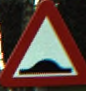

In [27]:
df = BelgiumTSC_val[BelgiumTSC_val['ClassId'] == class_id].copy()
df.reset_index(inplace=True)
img_name = df.loc[index, 'Filename']
bbox = [df.loc[index, 'Roi.X1'], df.loc[index, 'Roi.Y1'], df.loc[index, 'Roi.X2'], df.loc[index, 'Roi.Y2']]
index+=1
Image.open(os.path.join(dataset_path, 'BelgiumTSC', img_name)).crop(bbox)

Приведение валидационной выборки GTSRB к виду RTSD

In [28]:
# Формирование датафрейма из валидационной выборки
BelgiumTSC_val = pd.DataFrame()
list_directory = os.listdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing'))
for directory in list_directory:
    if os.path.isdir(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory)) == True:
        df_temp = pd.read_csv(os.path.join(dataset_path, 'BelgiumTSC', 'BelgiumTSC_Testing', 'Testing', directory, f"GT-{directory}.csv"), sep = ';')
        for i in range(len(df_temp)):
            df_temp.loc[i, 'Filename'] = f'BelgiumTSC_Testing/Testing/{directory}/' + df_temp.loc[i, 'Filename']
        BelgiumTSC_val = pd.concat((BelgiumTSC_val, df_temp), ignore_index=True)


# Корректировка пути к изображению
BelgiumTSC_val['Filename'] = BelgiumTSC_val['Filename'].apply(lambda x: 'BelgiumTSC/' + x)
# Формирование столбца bbox в формате COCO (x1, y1, w, h)
BelgiumTSC_val.reset_index(inplace=True) 
BelgiumTSC_val['bbox'] = BelgiumTSC_val['index'].apply(lambda x: [BelgiumTSC_val.at[x,'Roi.X1'], BelgiumTSC_val.at[x,'Roi.Y1'],
                                                                  BelgiumTSC_val.at[x,'Roi.X2'] - BelgiumTSC_val.at[x,'Roi.X1'],
                                                                  BelgiumTSC_val.at[x,'Roi.Y2'] - BelgiumTSC_val.at[x,'Roi.Y1']
                                                                  ])
# Добавим российские коды знаков (ГОСТ) в датасет
BelgiumTSC_val = BelgiumTSC_val.merge(pd.DataFrame([BelgiumTSC_to_RTSD_labels]).T, left_on='ClassId', right_index=True)
# Добавим ID категорий знаков из RTSD
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
BelgiumTSC_val = BelgiumTSC_val.merge(pd.DataFrame([label_map]).T, left_on=0, right_index=True)
# Оставим нужные колонки и переименуем их
BelgiumTSC_val.rename(columns={'Filename':'file_name', 'Width':'width', 'Height':'height', '0_x':'name', '0_y':'category_id'}, inplace=True)
BelgiumTSC_val = BelgiumTSC_val[['file_name','width','height','bbox','category_id','name']]
# сброс индекса
BelgiumTSC_val.reset_index(inplace=True)
del BelgiumTSC_val['index']

BelgiumTSC_val

,file_name,width,height,bbox,category_id,name
0,BelgiumTSC/BelgiumTSC_Testing/Testing/00031/02...,127,54,"[11, 5, 104, 43]",71,3_20
1,BelgiumTSC/BelgiumTSC_Testing/Testing/00031/02...,133,54,"[11, 5, 111, 44]",71,3_20
2,BelgiumTSC/BelgiumTSC_Testing/Testing/00031/02...,121,54,"[10, 5, 100, 43]",71,3_20
3,BelgiumTSC/BelgiumTSC_Testing/Testing/00031/02...,57,58,"[5, 5, 46, 47]",71,3_20
4,BelgiumTSC/BelgiumTSC_Testing/Testing/00031/02...,99,103,"[8, 9, 83, 84]",71,3_20
...,...,...,...,...,...,...
1774,BelgiumTSC/BelgiumTSC_Testing/Testing/00028/00...,108,85,"[9, 7, 89, 71]",72,3_2
1775,BelgiumTSC/BelgiumTSC_Testing/Testing/00028/00...,98,104,"[8, 9, 82, 85]",72,3_2
1776,BelgiumTSC/BelgiumTSC_Testing/Testing/00044/02...,43,30,"[5, 5, 33, 20]",114,2_7
1777,BelgiumTSC/BelgiumTSC_Testing/Testing/00044/02...,60,42,"[5, 5, 49, 31]",114,2_7


Формирование файла аннотации BelgiumTSC Val

In [29]:
BelgiumTSC_val_anno = make_df_to_anno(df = BelgiumTSC_val)
# сохранение аннотации в файл
with open(os.path.join(dataset_path, 'BelgiumTSC_val_anno.json'), 'w') as f:
    json.dump(BelgiumTSC_val_anno, f, cls=NpEncoder)
f.close()

## Датасет Chinese Traffic Signs
https://www.kaggle.com/datasets/dmitryyemelyanov/chinese-traffic-signs

Датасет содержит каталог с изображениями images и файл с аннотацией annotations.csv

In [30]:
ChineseTS = pd.read_csv(os.path.join(dataset_path, 'ChineseTrafficSigns', 'annotations.csv'))
for i in range(len(ChineseTS)):
    ChineseTS.loc[i, 'file_name'] = 'images/' + ChineseTS.loc[i, 'file_name']
ChineseTS

,file_name,width,height,x1,y1,x2,y2,category
0,images/000_0001.png,134,128,19,7,120,117,0
1,images/000_0002.png,165,151,23,12,149,138,0
2,images/000_0003.png,128,122,22,14,116,105,0
3,images/000_0010.png,80,73,14,8,67,63,0
4,images/000_0011.png,186,174,36,15,155,157,0
...,...,...,...,...,...,...,...,...
6159,images/056_1_0018_1_j.png,122,94,25,20,80,79,56
6160,images/056_1_0019_1_j.png,224,207,39,39,188,178,56
6161,images/056_1_0020_1_j.png,128,115,32,30,89,79,56
6162,images/057_1_0001_1_j.png,100,95,21,22,74,75,57


Анализ знаков ChineseTS и сопоставление с российскими знаками

In [31]:
class_id = 20
index = 0

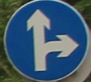

In [32]:
df = ChineseTS[ChineseTS['category'] == class_id].copy()
df.reset_index(inplace=True)
img_name = df.loc[index, 'file_name']
bbox = [df.loc[index, 'x1'], df.loc[index, 'y1'], df.loc[index, 'x2'], df.loc[index, 'y2']]
index+=1
Image.open(os.path.join(dataset_path, 'ChineseTrafficSigns', img_name)).crop(bbox)

**Расшифровка знаков ChineseTS и соотнесение с кодами российских знаков**
ClassId | Наименование знака | Код знака (ГОСТ)
|:---:|---|---|
0 | ограничение максимальной скорости (5) | 3_24
1 | ограничение максимальной скорости (15) | 3_24
2 | ограничение максимальной скорости (30) | 3_24
3 | ограничение максимальной скорости (40) | 3_24
4 | ограничение максимальной скорости (50) | 3_24
5 | ограничение максимальной скорости (60) | 3_24
6 | ограничение максимальной скорости (70) | 3_24
7 | ограничение максимальной скорости (80) | 3_24
8 | прямо и налево запрещено | -
9 | прямо и направо запрещено | -
10 | прямо запрещено | -
11 | Поворот налево запрещен | 3_18_2
12 | налево и направо запрещено | -
13 | Поворот направо запрещен | 3_18
14 | объезд запрещен | -
15 | разворот запрещен | 3_19
16 | движение механических транспортных средств запрещено | -
17 | Подача звукового сигнала запрещена | -
18 | Конец ограничения скорости (40) | 3_25
19 | Конец ограничения скорости (50) | 3_25
20 | Движение прямо и направо | 4_1_4
21 | Движение прямо | 4_1_1
22 | Движение налево | 4_1_3
23 | Движение направо или налево | 4_1_6
24 | Движение направо | 4_1_2
25 | Объезд слева | 4_2_2
26 | Объезд справа | 4_2_1
27 | Круговое движение | 4_3
28 | Дорога для автомобилей (не похоже) | 5_3
29 | Звуковой сигнал? | -
30 | Велосипедная зона? | -
31 | Место для разворота | 6_3_1
32 | Объезд с 2 сторон?? | -
33 | Светофор | 1_8
34 | Осторожно (только желтый) | 1_33
35 | Пешеходный переход (желтый) | 1_22
36 | Осторожно велосипедисты (в российских нет) | -
37 | Дети (не похож) | 1_23
38 | Странный объезд? | -
39 | Странный объезд? | -
40 | Спуск? | -
41 | Подъем? | -
42 | Иероглифы | -
43 | Примыкание второстепенной дороги (справа)+- | 2_3_2
44 | Примыкание второстепенной дороги (слева) +- | 2_3_3
45 | Дом отдыха? | -
46 | Зигзаги | -
47 | Железнодорожный переезд без шлагбаума +- | 1_2
48 | Дорожные работы | 1_25
49 | Зигзиги | -
50 | Железнодорожный переезд со шлагбаумом +- | 1_1
51 | ?? | -
52 | Иероглифы | -
53 | движение запрещено на квадратном фоне | -
54 | Остановка запрещена | 3_27
55 | Въезд запрещен (кирпич) | 3_1
56 | Иероглифы | -
57 | Видимо таможня и иероглифами | -

In [33]:
# Словарь с маппингом категорий ChineseTS на Российские знаки (которые есть в RTSD)
ChineseTS_to_RTSD_labels = {}
ChineseTS_to_RTSD_labels[0] = '3_24'                      
ChineseTS_to_RTSD_labels[1] = '3_24'
ChineseTS_to_RTSD_labels[2] = '3_24'
ChineseTS_to_RTSD_labels[3] = '3_24'
ChineseTS_to_RTSD_labels[4] = '3_24'
ChineseTS_to_RTSD_labels[5] = '3_24'
ChineseTS_to_RTSD_labels[6] = '3_24'
ChineseTS_to_RTSD_labels[7] = '3_24'
ChineseTS_to_RTSD_labels[11] = '3_18_2'
ChineseTS_to_RTSD_labels[13] = '3_18'
ChineseTS_to_RTSD_labels[15] = '3_19'
ChineseTS_to_RTSD_labels[18] = '3_25'
ChineseTS_to_RTSD_labels[19] = '3_25'
ChineseTS_to_RTSD_labels[20] = '4_1_4'
ChineseTS_to_RTSD_labels[21] = '4_1_1'
ChineseTS_to_RTSD_labels[22] = '4_1_3'
ChineseTS_to_RTSD_labels[23] = '4_1_6'
ChineseTS_to_RTSD_labels[24] = '4_1_2'
ChineseTS_to_RTSD_labels[25] = '4_2_2'
ChineseTS_to_RTSD_labels[26] = '4_2_1'
ChineseTS_to_RTSD_labels[27] = '4_3'
ChineseTS_to_RTSD_labels[28] = '5_3'
ChineseTS_to_RTSD_labels[31] = '6_3_1'
ChineseTS_to_RTSD_labels[33] = '1_8'
ChineseTS_to_RTSD_labels[34] = '1_33'
ChineseTS_to_RTSD_labels[35] = '1_22'
ChineseTS_to_RTSD_labels[37] = '1_23'
ChineseTS_to_RTSD_labels[43] = '2_3_2'
ChineseTS_to_RTSD_labels[44] = '2_3_3'
ChineseTS_to_RTSD_labels[47] = '1_2'
ChineseTS_to_RTSD_labels[48] = '1_25'
ChineseTS_to_RTSD_labels[50] = '1_1'
ChineseTS_to_RTSD_labels[54] = '3_27'
ChineseTS_to_RTSD_labels[55] = '3_1'
ChineseTS_to_RTSD_labels

{0: '3_24',
 1: '3_24',
 2: '3_24',
 3: '3_24',
 4: '3_24',
 5: '3_24',
 6: '3_24',
 7: '3_24',
 11: '3_18_2',
 13: '3_18',
 15: '3_19',
 18: '3_25',
 19: '3_25',
 20: '4_1_4',
 21: '4_1_1',
 22: '4_1_3',
 23: '4_1_6',
 24: '4_1_2',
 25: '4_2_2',
 26: '4_2_1',
 27: '4_3',
 28: '5_3',
 31: '6_3_1',
 33: '1_8',
 34: '1_33',
 35: '1_22',
 37: '1_23',
 43: '2_3_2',
 44: '2_3_3',
 47: '1_2',
 48: '1_25',
 50: '1_1',
 54: '3_27',
 55: '3_1'}

Примечания:
- Знак категории 28 - Дорога для автомобилей (не похоже)            5_3;
- Знак категории 43 - Примыкание второстепенной дороги (справа)+-   2_3_2;
- Знак категории 44 - Примыкание второстепенной дороги (слева) +-   2_3_3;
- Знак категории 47 - Железнодорожный переезд без шлагбаума +-      1_2;
- Знак категории 50 - Железнодорожный переезд со шлагбаумом +-       1_1.

Приведение ChineseTS к виду RTSD

In [34]:
# Формирование датафрейма (выборка одна)
ChineseTS = pd.read_csv(os.path.join(dataset_path, 'ChineseTrafficSigns', 'annotations.csv'))
# Корректировка пути к изображению
ChineseTS['file_name'] = ChineseTS['file_name'].apply(lambda x: 'ChineseTrafficSigns/images/' + x)
# Формирование столбца bbox в формате COCO (x1, y1, w, h)
ChineseTS.reset_index(inplace=True) 
ChineseTS['bbox'] = ChineseTS['index'].apply(lambda x: [ChineseTS.at[x,'x1'], ChineseTS.at[x,'y1'],
                                                        ChineseTS.at[x,'x2'] - ChineseTS.at[x,'x1'],
                                                        ChineseTS.at[x,'y2'] - ChineseTS.at[x,'y1']
                                                        ])
# Добавим российские коды знаков (ГОСТ) в датасет
ChineseTS = ChineseTS.merge(pd.DataFrame([ChineseTS_to_RTSD_labels]).T, left_on='category', right_index=True)
# Добавим ID категорий знаков из RTSD
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
ChineseTS = ChineseTS.merge(pd.DataFrame([label_map]).T, left_on=0, right_index=True)
# Оставим нужные колонки и переименуем их
ChineseTS.rename(columns={'0_x':'name', '0_y':'category_id'}, inplace=True)
ChineseTS = ChineseTS[['file_name','width','height','bbox','category_id','name']]
# сброс индекса
ChineseTS.reset_index(inplace=True)
del ChineseTS['index']

ChineseTS

,file_name,width,height,bbox,category_id,name
0,ChineseTrafficSigns/images/000_0001.png,134,128,"[19, 7, 101, 110]",4,3_24
1,ChineseTrafficSigns/images/000_0002.png,165,151,"[23, 12, 126, 126]",4,3_24
2,ChineseTrafficSigns/images/000_0003.png,128,122,"[22, 14, 94, 91]",4,3_24
3,ChineseTrafficSigns/images/000_0010.png,80,73,"[14, 8, 53, 55]",4,3_24
4,ChineseTrafficSigns/images/000_0011.png,186,174,"[36, 15, 119, 142]",4,3_24
...,...,...,...,...,...,...
4359,ChineseTrafficSigns/images/055_1_0025_1_j.png,88,93,"[30, 25, 36, 46]",69,3_1
4360,ChineseTrafficSigns/images/055_1_0026_1_j.png,93,97,"[21, 23, 53, 52]",69,3_1
4361,ChineseTrafficSigns/images/055_1_0027_1_j.png,104,99,"[25, 20, 49, 49]",69,3_1
4362,ChineseTrafficSigns/images/055_1_0028_1_j.png,141,134,"[24, 19, 86, 84]",69,3_1


Формирование файла аннотации ChineseTS

In [35]:
ChineseTS_anno = make_df_to_anno(df = ChineseTS)
# сохранение аннотации в файл
with open(os.path.join(dataset_path, 'ChineseTS_anno.json'), 'w') as f:
    json.dump(ChineseTS_anno, f, cls=NpEncoder)
f.close()

## Визуализация распределения знаков по датасетам

In [36]:
# Распределение частоты появления знаков в RTSD_train
RTSD_train_distribution = pd.DataFrame(RTSD_train['name'].value_counts().sort_index())
RTSD_train_distribution.rename(columns={'name': 'RTSD_train'},inplace=True)

# Распределение частоты появления знаков в GTSRB_train
GTSRB_train_distribution = pd.DataFrame(GTSRB_train['name'].value_counts())
GTSRB_train_distribution.rename(columns={'name': 'GTSRB_train'},inplace=True)

# Распределение частоты появления знаков в GTSRB_val
GTSRB_val_distribution = pd.DataFrame(GTSRB_val['name'].value_counts())
GTSRB_val_distribution.rename(columns={'name': 'GTSRB_val'},inplace=True)

# Распределение частоты появления знаков в BelgiumTSC_train
BelgiumTSC_train_distribution = pd.DataFrame(BelgiumTSC_train['name'].value_counts())
BelgiumTSC_train_distribution.rename(columns={'name': 'BelgiumTSC_train'},inplace=True)

# Распределение частоты появления знаков в BelgiumTSC_val
BelgiumTSC_val_distribution = pd.DataFrame(BelgiumTSC_val['name'].value_counts())
BelgiumTSC_val_distribution.rename(columns={'name': 'BelgiumTSC_val'},inplace=True)

# Распределение частоты появления знаков в ChineseTS
ChineseTS_distribution = pd.DataFrame(ChineseTS['name'].value_counts())
ChineseTS_distribution.rename(columns={'name': 'ChineseTS'},inplace=True)

# Результирующий датасет
counts_signs_all = pd.merge(RTSD_train_distribution, GTSRB_train_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, GTSRB_val_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, BelgiumTSC_train_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, BelgiumTSC_val_distribution, left_index=True, right_index=True, how='left')
counts_signs_all = pd.merge(counts_signs_all, ChineseTS_distribution, left_index=True, right_index=True, how='left')

# Заменим пропуски нулями
counts_signs_all = counts_signs_all.fillna(0)
counts_signs_all['GTSRB_train'] = counts_signs_all['GTSRB_train'].astype(int)
counts_signs_all['GTSRB_val'] = counts_signs_all['GTSRB_val'].astype(int)
counts_signs_all['BelgiumTSC_train'] = counts_signs_all['BelgiumTSC_train'].astype(int)
counts_signs_all['BelgiumTSC_val'] = counts_signs_all['BelgiumTSC_val'].astype(int)
counts_signs_all['ChineseTS'] = counts_signs_all['ChineseTS'].astype(int)

counts_signs_all

,RTSD_train,GTSRB_train,GTSRB_val,BelgiumTSC_train,BelgiumTSC_val,ChineseTS
1_1,205,0,0,18,3,76
1_10,18,0,0,0,0,0
1_11,350,360,90,15,12,0
1_11_1,441,210,60,15,6,0
1_12,171,0,0,18,6,0
...,...,...,...,...,...,...
8_5_2,78,0,0,0,0,0
8_5_4,83,0,0,0,0,0
8_6_2,23,0,0,0,0,0
8_6_4,37,0,0,0,0,0


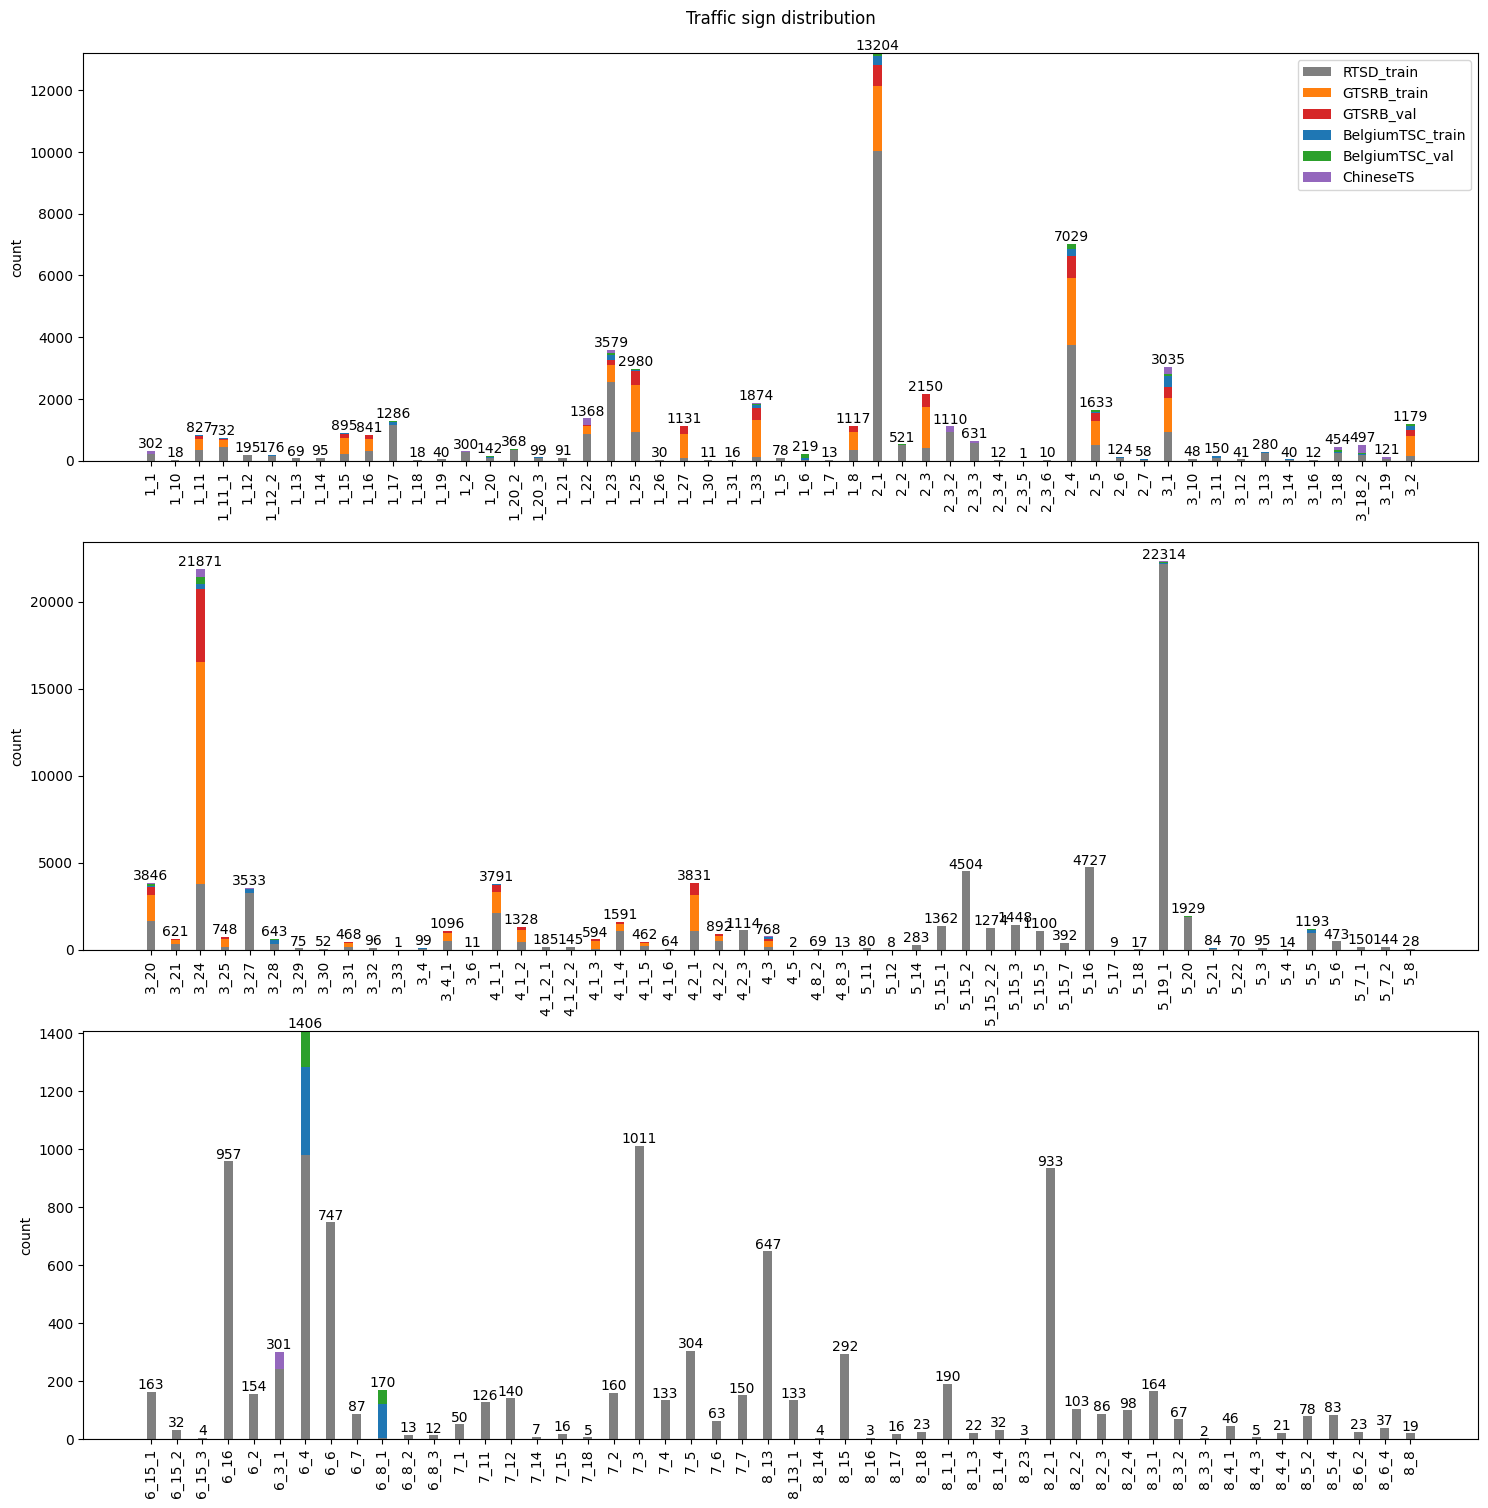

In [37]:
x1 = counts_signs_all.index[:53]   # the x locations for the groups
y1_1 = counts_signs_all.RTSD_train[:53]
y1_2 = counts_signs_all.GTSRB_train[:53]
y1_3 = counts_signs_all.GTSRB_val[:53]
y1_4 = counts_signs_all.BelgiumTSC_train[:53]
y1_5 = counts_signs_all.BelgiumTSC_val[:53]
y1_6 = counts_signs_all.ChineseTS[:53]

x2 = counts_signs_all.index[53:105]   # the x locations for the groups
y2_1 = counts_signs_all.RTSD_train[53:105]
y2_2 = counts_signs_all.GTSRB_train[53:105]
y2_3 = counts_signs_all.GTSRB_val[53:105]
y2_4 = counts_signs_all.BelgiumTSC_train[53:105]
y2_5 = counts_signs_all.BelgiumTSC_val[53:105]
y2_6 = counts_signs_all.ChineseTS[53:105]

x3 = counts_signs_all.index[105:]   # the x locations for the groups
y3_1 = counts_signs_all.RTSD_train[105:]
y3_2 = counts_signs_all.GTSRB_train[105:]
y3_3 = counts_signs_all.GTSRB_val[105:]
y3_4 = counts_signs_all.BelgiumTSC_train[105:]
y3_5 = counts_signs_all.BelgiumTSC_val[105:]
y3_6 = counts_signs_all.ChineseTS[105:]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(nrows=3,ncols=1)
ax1, ax2, ax3 = ax.flatten()

p1_1 = ax1.bar(x1 , y1_1, width, label='RTSD_train', color='#7f7f7f')
p1_2 = ax1.bar(x1 , y1_2, width, bottom=y1_1, label='GTSRB_train', color='#ff7f0e')
p1_3 = ax1.bar(x1 , y1_3, width, bottom=y1_1+y1_2, label='GTSRB_val', color='#d62728')
p1_4 = ax1.bar(x1 , y1_4, width, bottom=y1_1+y1_2+y1_3, label='BelgiumTSC_train', color='#1f77b4')
p1_5 = ax1.bar(x1 , y1_5, width, bottom=y1_1+y1_2+y1_3+y1_4, label='BelgiumTSC_val', color='#2ca02c')
p1_6 = ax1.bar(x1 , y1_6, width, bottom=y1_1+y1_2+y1_3+y1_4+y1_5, label='ChineseTS', color='#9467bd')

ax1.axhline(0, color='grey', linewidth=0.8)
#ax1.set_yscale('log')
ax1.set_ylabel('count')
ax1.set_title('Traffic sign distribution\n')
ax1.set_xticks(x1, x1, rotation=90)
ax1.legend()
ax1.bar_label(p1_6)

p2_1 = ax2.bar(x2 , y2_1, width, label='RTSD_train', color='#7f7f7f')
p2_2 = ax2.bar(x2 , y2_2, width, bottom=y2_1, label='GTSRB_train', color='#ff7f0e')
p2_3 = ax2.bar(x2 , y2_3, width, bottom=y2_1+y2_2, label='GTSRB_val', color='#d62728')
p2_4 = ax2.bar(x2 , y2_4, width, bottom=y2_1+y2_2+y2_3, label='BelgiumTSC_train', color='#1f77b4')
p2_5 = ax2.bar(x2 , y2_5, width, bottom=y2_1+y2_2+y2_3+y2_4, label='BelgiumTSC_val', color='#2ca02c')
p2_6 = ax2.bar(x2 , y2_5, width, bottom=y2_1+y2_2+y2_3+y2_4+y2_5, label='ChineseTS', color='#9467bd')

ax2.axhline(0, color='grey', linewidth=0.8)
#ax2.set_yscale('log')
ax2.set_ylabel('count')
ax2.set_xticks(x2, x2, rotation=90)
ax2.bar_label(p2_6)

p3_1 = ax3.bar(x3, y3_1, width, label='RTSD_train', color='#7f7f7f')
p3_2 = ax3.bar(x3, y3_2, width, bottom=y3_1, label='GTSRB_train', color='#ff7f0e')
p3_3 = ax3.bar(x3 , y3_3, width, bottom=y3_1+y3_2, label='GTSRB_val', color='#d62728')
p3_4 = ax3.bar(x3 , y3_4, width, bottom=y3_1+y3_2+y3_3, label='BelgiumTSC_train', color='#1f77b4')
p3_5 = ax3.bar(x3 , y3_5, width, bottom=y3_1+y3_2+y3_3+y3_4, label='BelgiumTSC_val', color='#2ca02c')
p3_6 = ax3.bar(x3 , y3_6, width, bottom=y3_1+y3_2+y3_3+y3_4+y3_5, label='ChineseTS', color='#9467bd')

ax3.axhline(0, color='grey', linewidth=0.8)
#ax3.set_yscale('log')
ax3.set_ylabel('count')
ax3.set_xticks(x3, x3, rotation=90)
ax3.bar_label(p3_6)

fig.set_size_inches(18,18)
plt.show()

Примечания:  
-     Датасет немецких знаков
- Знак категорий 0-5, 7, 8 Ограничение максимальной скорости                        '3_24'; - в RSTD их много, немного отличаются, выкидываем
- Знак категории 11 - Пересечение со второстепенной дорогой (немного отличается)    '2_3'; - слишком большой вес - выкидываем
-     Датасет бельгийских знаков
- Знак категории 24 - Ограничение по массе (немного не похоже)  '3_11' - выкидываем, отличается
-     Датасет китайских знаков
- Знак категории 28 - Дорога для автомобилей (не похоже)            5_3; - убираем, слишком большой вес
- Знак категории 43 - Примыкание второстепенной дороги (справа)+-   2_3_2; - убираем, сильно отличается
- Знак категории 44 - Примыкание второстепенной дороги (слева) +-   2_3_3; - убираем, сильно отличается
- Знак категории 47 - Железнодорожный переезд без шлагбаума +-      1_2; - убираем, сильно отличается
- Знак категории 50 - Железнодорожный переезд со шлагбаумом +-       1_1; - убираем, сильно отличается